# WRT - AT - Technical Assessment - EDA
Notebook for modelling the cleaned (deduplicated, missing value imputed, column dropped) data to predict the price variable.

# Setup

In [43]:
# load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)
from sklearn.preprocessing import StandardScaler
import category_encoders as ce
from tqdm import tqdm
from sklearn.ensemble import GradientBoostingRegressor

In [44]:
# setup notebook
pd.set_option("display.max_columns", None)

# Load

In [45]:
# load data
directory_path = "/Users/nb1777/Git/wrt_at"
file_path = (
    "vehicle_price_prediction/vehicle_price_prediction/data/at_vehicle_data_clean.csv"
)
df_in = pd.read_csv("/".join([directory_path, file_path]))

# Examine

In [46]:
df_in.head(10)

,make,model,body_type,fuel_type,engine_size,transmission,year,mileage,price,colour,area,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,price_position
0,BMW,X1,SUV,Petrol,2.0,Automatic,2021.0,13434,32000,Blue,BS,1,1,1,0,1,1,0,1,1,1,100.4
1,BMW,2 Series Gran Coupe,Saloon,Petrol,1.5,Automatic,2021.0,6347,32898,Blue,G,1,0,1,0,0,0,1,0,0,0,111.3
2,BMW,2 Series Gran Coupe,Saloon,Petrol,1.5,Manual,2021.0,10,35510,Blue,PE,1,1,1,0,1,0,1,1,0,0,NaN
3,BMW,4 Series,Coupe,Diesel Hybrid,2.0,Automatic,2022.0,6500,37999,Grey,B,1,1,1,0,1,1,1,0,0,0,102.5
4,BMW,1 Series,Hatchback,Diesel,2.0,Manual,2012.0,136952,4890,Black,S,0,0,0,0,0,0,0,0,0,0,99.1
5,BMW,2 Series Gran Tourer,MPV,Diesel,2.0,Automatic,2017.0,48690,19200,Silver,PE,0,0,0,0,0,1,0,1,0,0,104.1
6,BMW,2 Series,Coupe,Petrol,1.5,Manual,2018.0,14000,19990,Grey,BN,1,1,1,0,0,1,1,0,1,0,111.6
7,BMW,X4,SUV,Diesel Hybrid,2.0,Automatic,2021.0,14708,44990,Blue,PH,0,0,0,1,1,0,1,0,0,0,102.5
8,BMW,2 Series Active Tourer,MPV,Petrol,1.5,Manual,2018.0,29745,16000,Black,WN,0,0,1,0,0,0,0,0,0,0,107.3
9,BMW,7 Series,Saloon,Diesel,3.0,Automatic,2019.0,22370,37750,Multicolour,EH,0,0,0,0,0,1,0,0,0,0,91.4


In [47]:
# missing values
df_in.isna().sum()

make                0
model               0
body_type           0
fuel_type           0
engine_size         0
transmission        0
year                0
mileage             0
price               0
colour              0
area                0
feature_1           0
feature_2           0
feature_3           0
feature_4           0
feature_5           0
feature_6           0
feature_7           0
feature_8           0
feature_9           0
feature_10          0
price_position    984
dtype: int64

In [48]:
# drop `price_position` - not needed for modelling
df = df_in.drop(["price_position"], axis=1)
print(df.shape)

(9522, 21)


# Considerations

- outlier detection?
- data sparsity?
- dimensionality scaling?
- dimensionality reduction?
- hyperparameter tuning?

# Functions
- function to calculate model performance
- function to get feature importance
- function to get and plot model metrics

In [49]:
def get_importance(model, features, model_type):
    """
    Calculate feature importance based on the model type.

    Parameters:
    - model: scikit-learn regression model
        The fitted model to extract importances from.
    - X_train: array-like, shape (n_samples, n_features)
        Training feature set.
    - model_type: str
        The type of model (e.g., 'LR', 'RF', 'GB').

    Returns:
    - pd.DataFrame
        A DataFrame containing variable names and their importance values.
    """
    if model_type == "LR":
        # For Linear Regression, get coefficients
        importance = model.coef_
        importances = {"Variable": features, "Importance": importance}

    elif model_type in ["RF", "GB"]:
        # For Random Forest or Gradient Boosting, get feature importances
        importance = model.feature_importances_
        importances = {"Variable": features, "Importance": importance}

    else:
        # TBC for other models
        importances = {"Variable": ["TBC"], "Importance": [None]}

    # Print out the importance
    print(f"\n{'Metric':<40} {'Importance':<10}")
    print("-" * 50)
    for index, row in pd.DataFrame(importances).iterrows():
        print(f"{row['Variable']:<40}: {row['Importance']:.4f}")

    return importances

In [50]:
def evaluate_model(
    model,
    features,
    X_train,
    X_test,
    y_train,
    y_test,
    model_type,
    model_variant,
    model_description,
    print_metrics=True,
    return_importance=True,
):
    """
    Evaluate a regression model using various performance metrics.

    Parameters:
    - model: scikit-learn regression model
        The regression model to be evaluated.
    - features: array, shape (n_features)
        Training feature names.
    - X_train: array-like, shape (n_samples, n_features)
        Training feature set.
    - X_test: array-like, shape (n_samples, n_features)
        Testing feature set.
    - y_train: array-like, shape (n_samples,)
        Training target variable.
    - y_test: array-like, shape (n_samples,)
        Testing target variable.
    - model_type: str
        The type of model (e.g., 'LR', 'RF', 'GB').
    - model_variant: str
        A variant of the model type.
    - model_description: str
        A description of the model.

    Returns:
    - pd.DataFrame
        A DataFrame containing the calculated metrics for the model.
    - pd.DataFrame
        A DataFrame containing coefficients or feature importances.
    """

    # fit model
    model.fit(X_train, y_train)

    # predict using test data
    y_pred = model.predict(X_test)

    # calculate metrics
    metrics = {
        "Model": model_type,
        "Model-Desc": " - ".join([model_type + model_variant, model_description]),
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": root_mean_squared_error(y_test, y_pred),
        "MAPE": mean_absolute_percentage_error(y_test, y_pred)
        * 100,  # MAPE in percentage
        "R-squared": r2_score(y_test, y_pred),
        "Adj-R-squared": 1
        - (1 - r2_score(y_test, y_pred))
        * (len(y_test) - 1)
        / (len(y_test) - X_test.shape[1] - 1),
    }

    # print metrics
    if print_metrics:
        print(f"{'Metric':<20} {'Value':<10}")
        print("-" * 30)
        for key, value in metrics.items():
            if "Model" in key:
                print(f"{key:<20}: {value}")
            else:
                print(f"{key:<20}: {value:.4f}")

    # store metrics in dataframe

    # feature importance
    importances = None
    if return_importance:
        importances = get_importance(model, features, model_type)

    return metrics, importances

In [51]:
def generate_plot(df_model_metrics, model_name):
    """
    Generate scatter plots of model metrics over iterations and calculate
    their average and standard deviation.

    Parameters:
    - df_model_metrics: pd.DataFrame
        A DataFrame containing model metrics for different iterations.
        The DataFrame should have metrics as columns and iterations as rows.

    - model_name: str
        The name of the model being evaluated. This will be used in the plot title
        and when printing the average metric values.

    Returns:
    - pd.DataFrame
        A DataFrame containing the model name, metric names, their mean, and
        standard deviation for the metrics plotted.

    The function creates a subplot for each metric, displaying individual
    metric values for each iteration. It also includes a horizontal line
    representing the average value of each metric.
    """

    # create subplots
    fig, axs = plt.subplots(1, 6, figsize=(24, 6))

    metric_results = []
    i = 0
    print(f"\n{'Metric':<20} {'Value':<10}")
    print("-" * 30)
    for mtr in df_model_metrics.columns:
        # only process true metric values (not model name)
        if "Model" not in mtr:
            # calculate average and standard deviation
            mean_value = df_model_metrics[mtr].mean()
            std_value = df_model_metrics[mtr].std()
            metric_results.append(
                {
                    "Model": model_name,
                    "Metric": mtr,
                    "Mean": float(mean_value),
                    "Std": float(std_value),
                }
            )

            # print
            print(f"{mtr:<20}: {mean_value:.3f}")

            # plot metrics
            axs[i].scatter(
                df_model_metrics.index,
                df_model_metrics[mtr],
                color=sns.color_palette()[i],
            )
            axs[i].axhline(
                y=mean_value, color="black", linestyle="--", label=f"Average {mtr}"
            )
            axs[i].set_title(f"{mtr}")
            axs[i].set_xlabel("Iteration")
            axs[i].set_ylabel(mtr)

            # iterate
            i += 1

    plt.suptitle(model_name, fontsize=16)  # Set the main title for the entire figure
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(metric_results)

# Investigate

In [52]:
# data frame to store model performance metrics
df_metrics = pd.DataFrame()

# samples
n_samples = 20

- Linear Regression:
    - simple to implement and provides interpretable results. Linear regression works well if there’s a linear relationship between the features and the target
    - assumes a linear relationship between features and price, so it might struggle with more complex patterns in the data

- Random Forest Regressor:
    - powerful, non-linear model that can handle both numerical and categorical data (though the categorical data still needs encoding). It’s good for datasets with mixed data types and can capture non-linear relationships well.

- Gradient Boosting Machines (XGBoost)
    - top-performing models for many structured data problems
    - handle non-linear relationships, capture interactions between features, and often outperform traditional models like linear regression
    - highly flexible, powerful, and tend to outperform simpler models, especially when there's a complex relationship between features and the target variable

- Neural Networks
    - advanced approach that can capture complex patterns in the data. They can handle both numerical and categorical data (with proper preprocessing) and capture deep interactions between features
    - data-hungry and computationally expensive compared to tree-based methods like RandomForest or Gradient Boosting

### Linear Regression (LR)

#### Model1 - LR (year)

From the EDA analysis, it was shown that year had the greatest magnitude of correlation with the price, so we'll create a baseline linear regression model that uses a this single variable to predict the price.

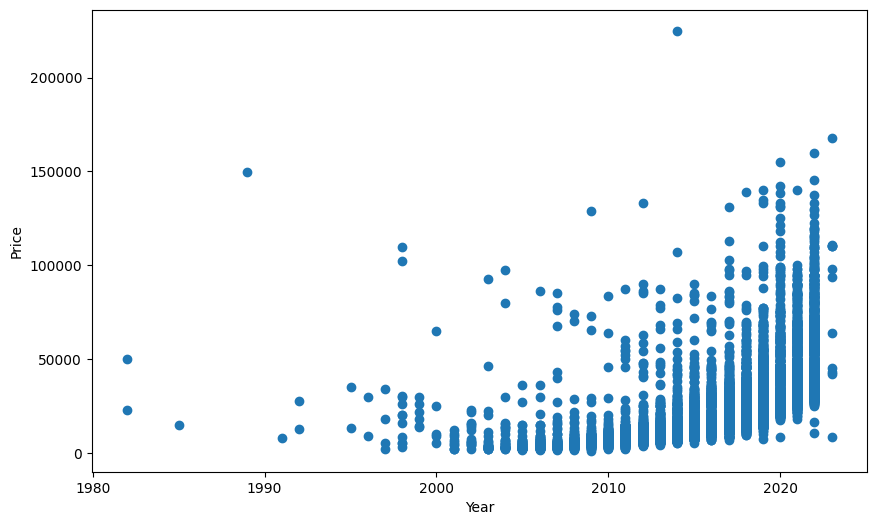

In [53]:
# plot year - price
plt.figure(figsize=(10, 6))
plt.scatter(x=df["year"], y=df["price"])
plt.xlabel("Year")
plt.ylabel("Price")
plt.show()

In [54]:
# create a random test-train split
X = df[["year"]]
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# variables
features = X.columns
numeric_features = ["year"]

# scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[numeric_features])
X_test = scaler.fit_transform(X_test[numeric_features])

# linear regression model
model = LinearRegression()
metrics, importances = evaluate_model(
    model,
    features,
    X_train,
    X_test,
    y_train,
    y_test,
    model_type="LR",
    model_variant="1",
    model_description="year",
)

Metric               Value     
------------------------------
Model               : LR
Model-Desc          : LR1 - year
MAE                 : 10023.3740
MSE                 : 229771274.3893
RMSE                : 15158.2082
MAPE                : 48.6496
R-squared           : 0.3558
Adj-R-squared       : 0.3554

Metric                                   Importance
--------------------------------------------------
year                                    : 10897.0582


- year positively impacts price (the newer a vehicle is the more expensive the vehicle is)

Model Iterations:: 100%|██████████| 20/20 [00:00<00:00, 212.95it/s]


Metric               Value     
------------------------------
MAE                 : 10464.955
MSE                 : 254425816.949
RMSE                : 15938.695
MAPE                : 50.520
R-squared           : 0.326
Adj-R-squared       : 0.326


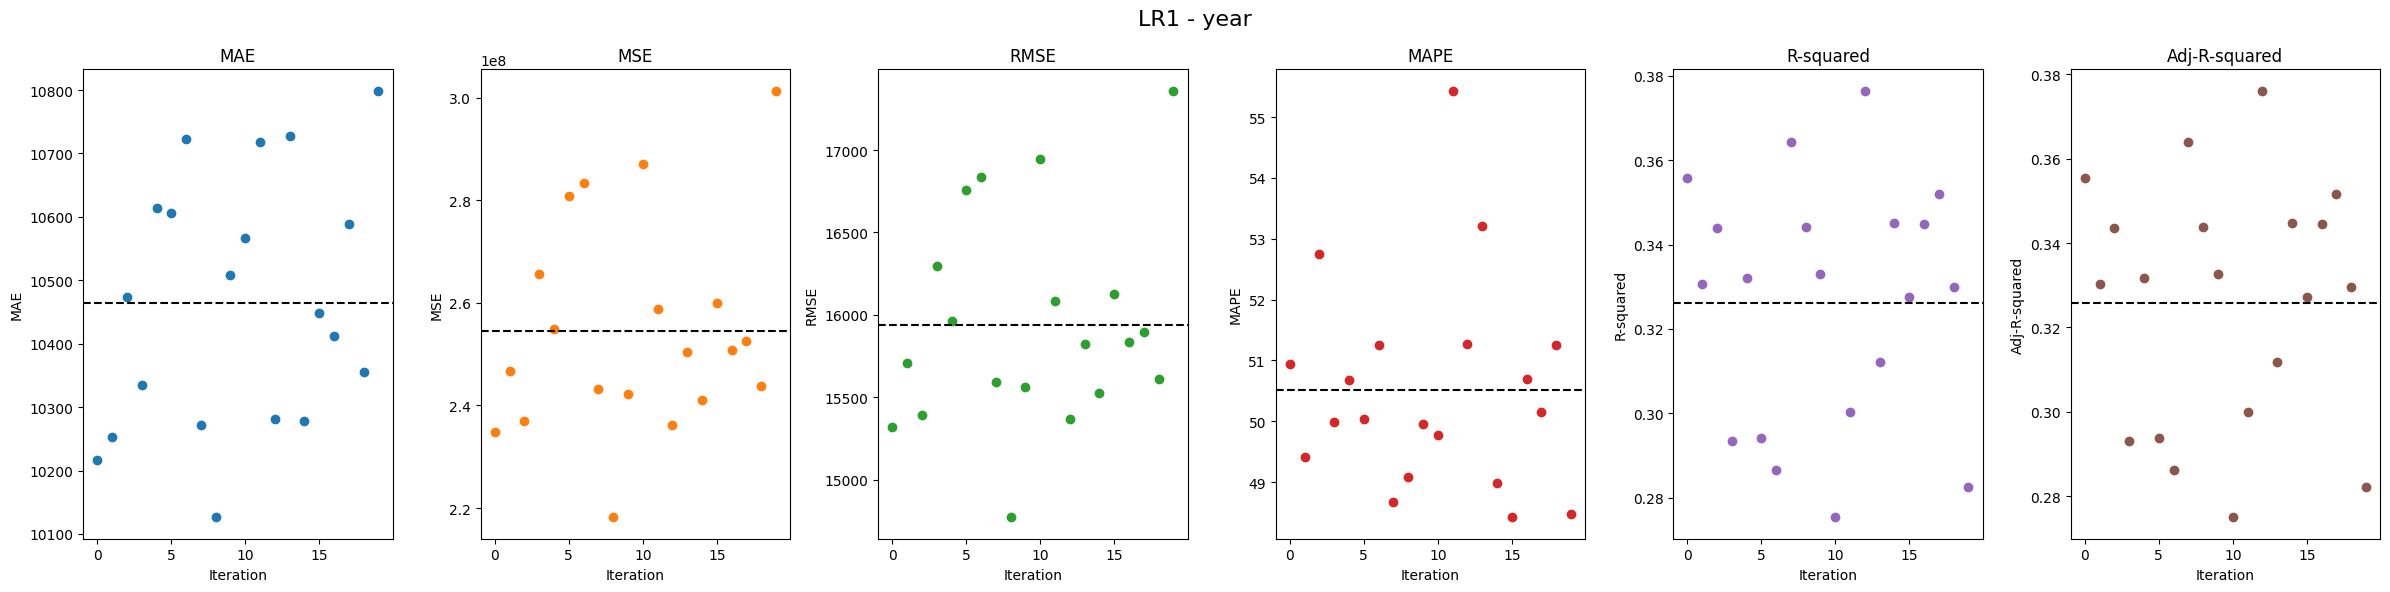

In [55]:
# apply LR model (over loop to generate 100 different models)

model_metrics = []

for i in tqdm(range(n_samples), desc="Model Iterations:"):
    # create a random test-train split
    X = df[["year"]]
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # variables
    features = X.columns
    numeric_features = ["year"]

    # scale numeric features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train[numeric_features])
    X_test = scaler.fit_transform(X_test[numeric_features])

    # linear regression model
    model = LinearRegression()
    metrics, importances = evaluate_model(
        model,
        features,
        X_train,
        X_test,
        y_train,
        y_test,
        model_type="LR",
        model_variant="1",
        model_description="year",
        print_metrics=False,
        return_importance=False,
    )

    model_metrics.append(metrics)

# plot and generate average metrics
df_model_metrics = pd.DataFrame(model_metrics)
df_model = generate_plot(df_model_metrics, df_model_metrics["Model-Desc"].unique()[0])
df_metrics = pd.concat([df_metrics, df_model])

- significantly large MSE
- low R-squared score, does a bad job of explaining variance
- WRT: add comments!

#### Model2 - LR (year, mileage)


From the EDA analysis, year and mileage were the two variables with the largest magnitudes of correlation with the target variable (price), so we'll create a Linear Regression model using these two variables to predict price.

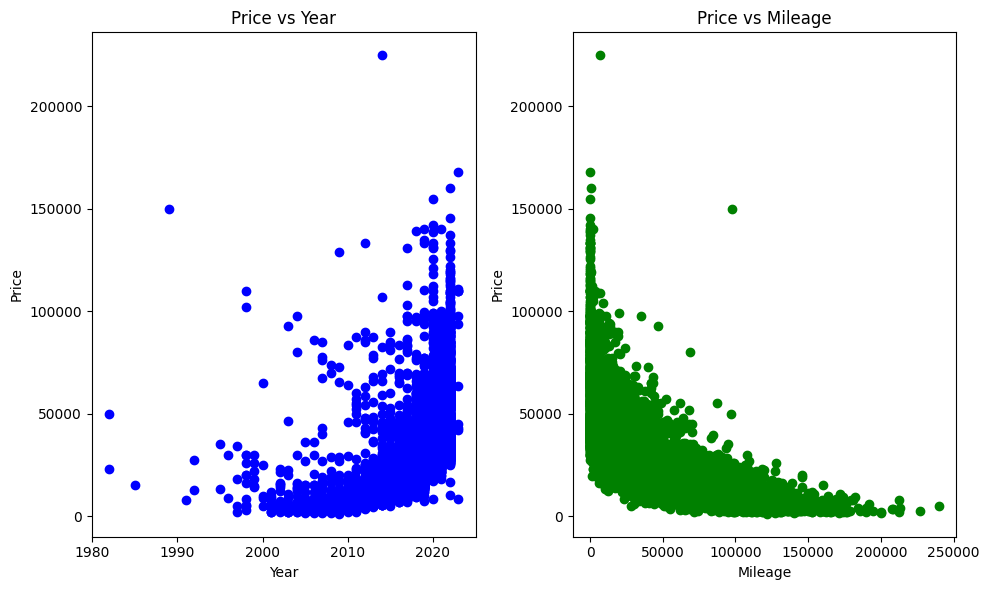

In [56]:
# plot year - price and mileage - price
fig, axs = plt.subplots(1, 2, figsize=(10, 6))

# year - price
axs[0].scatter(df["year"], df["price"], color="blue")
axs[0].set_title("Price vs Year")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Price")

# mileage-price
axs[1].scatter(df["mileage"], df["price"], color="green")
axs[1].set_title("Price vs Mileage")
axs[1].set_xlabel("Mileage")
axs[1].set_ylabel("Price")

plt.tight_layout()
plt.show()

In [57]:
# create a random test-train split
X = df[["year", "mileage"]]
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# variables
features = X.columns
numeric_features = ["year", "mileage"]

# scale numeric features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train[numeric_features])
X_test = scaler.fit_transform(X_test[numeric_features])

# linear regression model
model = LinearRegression()
metrics, importances = evaluate_model(
    model,
    features,
    X_train,
    X_test,
    y_train,
    y_test,
    model_type="LR",
    model_variant="2",
    model_description="year+mileage",
)

Metric               Value     
------------------------------
Model               : LR
Model-Desc          : LR2 - year+mileage
MAE                 : 9462.9172
MSE                 : 190657306.1979
RMSE                : 13807.8712
MAPE                : 48.2862
R-squared           : 0.4654
Adj-R-squared       : 0.4649

Metric                                   Importance
--------------------------------------------------
year                                    : 4058.6333
mileage                                 : -9878.6563


- mileage negatively impacts price (the more miles a vehicle has done, the cheaper the vehicle)

Model Iterations:: 100%|██████████| 20/20 [00:00<00:00, 193.72it/s]


Metric               Value     
------------------------------
MAE                 : 9733.080
MSE                 : 205908946.969
RMSE                : 14342.483
MAPE                : 49.177
R-squared           : 0.449
Adj-R-squared       : 0.449


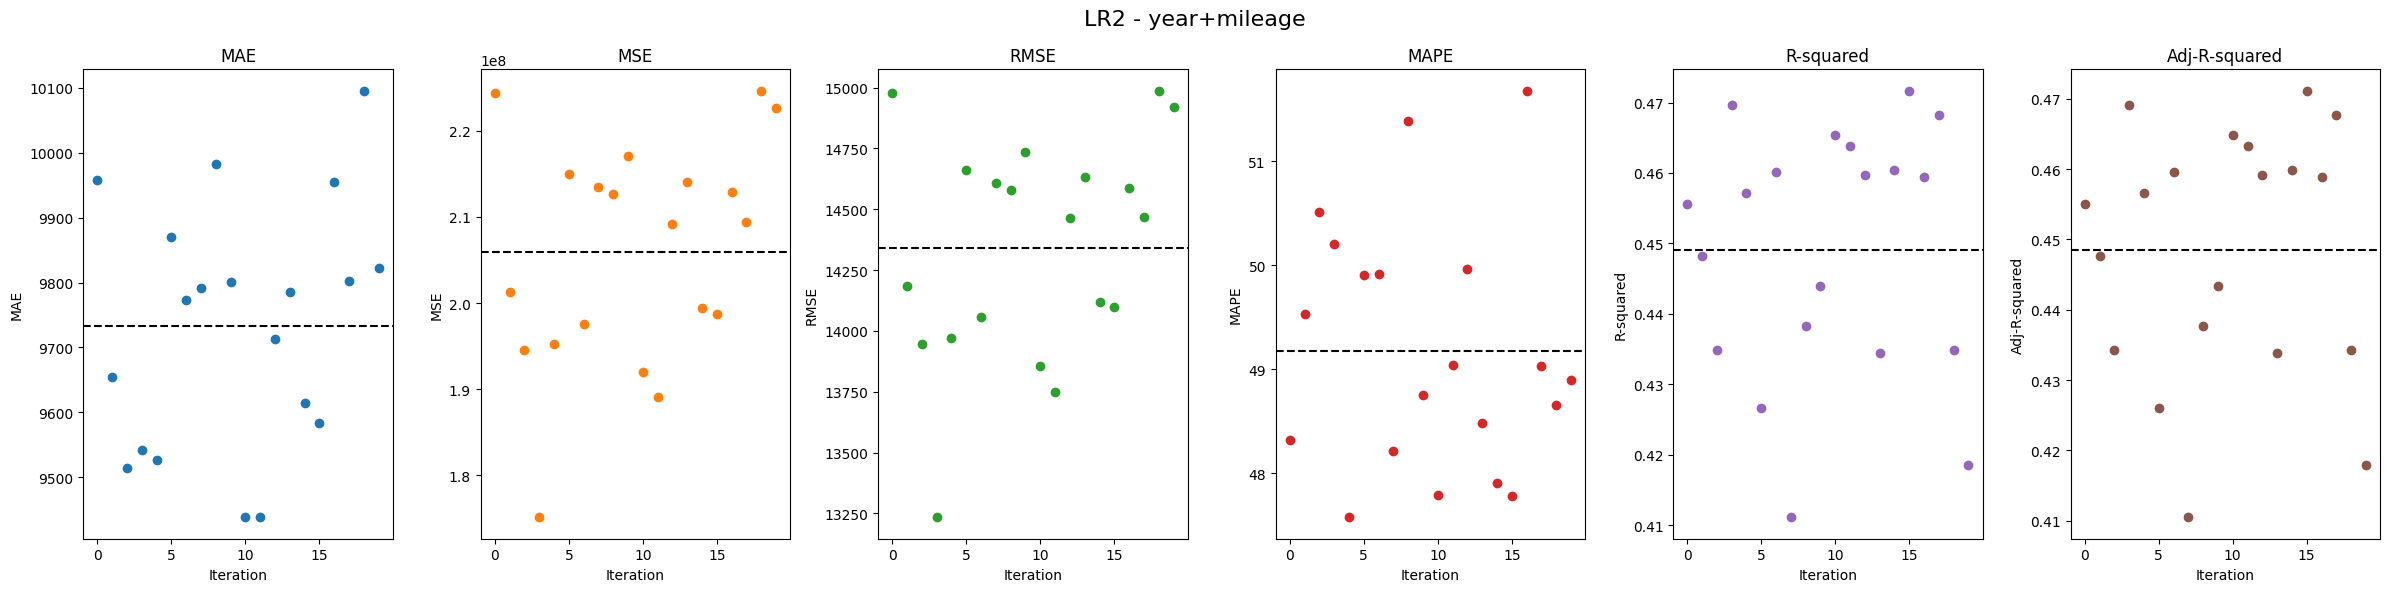

In [58]:
# apply LR model (over loop to generate 100 different models)

model_metrics = []

for i in tqdm(range(n_samples), desc="Model Iterations:"):
    # create a random test-train split
    X = df[["year", "mileage"]]
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # variables
    features = X.columns
    numeric_features = ["year", "mileage"]

    # scale numeric features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train[numeric_features])
    X_test = scaler.fit_transform(X_test[numeric_features])

    # linear regression model
    model = LinearRegression()
    metrics, importances = evaluate_model(
        model,
        features,
        X_train,
        X_test,
        y_train,
        y_test,
        model_type="LR",
        model_variant="2",
        model_description="year+mileage",
        print_metrics=False,
        return_importance=False,
    )

    model_metrics.append(metrics)

# plot and generate average metrics
df_model_metrics = pd.DataFrame(model_metrics)
df_model = generate_plot(df_model_metrics, df_model_metrics["Model-Desc"].unique()[0])
df_metrics = pd.concat([df_metrics, df_model])

- lower MSE, but still very high
- low R-squared score, captures more data variance than Model0, but still a low value

#### Model3 - LR (all numerical with correlation greater than 0.2)



From the EDA analysis, we can extract all numerical variables with a magnitude of correlation with the target variable (price) greater than 0.2 (arbitary value to select a range of features, but not all)

- engine_size   : 0.23
- year          : 0.64
- mileage       : -0.65
- feature_4     : 0.28
- feature_5     : 0.37
- feature_6     : -0.32

Model Iterations:: 100%|██████████| 20/20 [00:00<00:00, 183.60it/s]



Metric               Value     
------------------------------
MAE                 : 8408.372
MSE                 : 171185386.501
RMSE                : 13074.226
MAPE                : 44.039
R-squared           : 0.546
Adj-R-squared       : 0.545


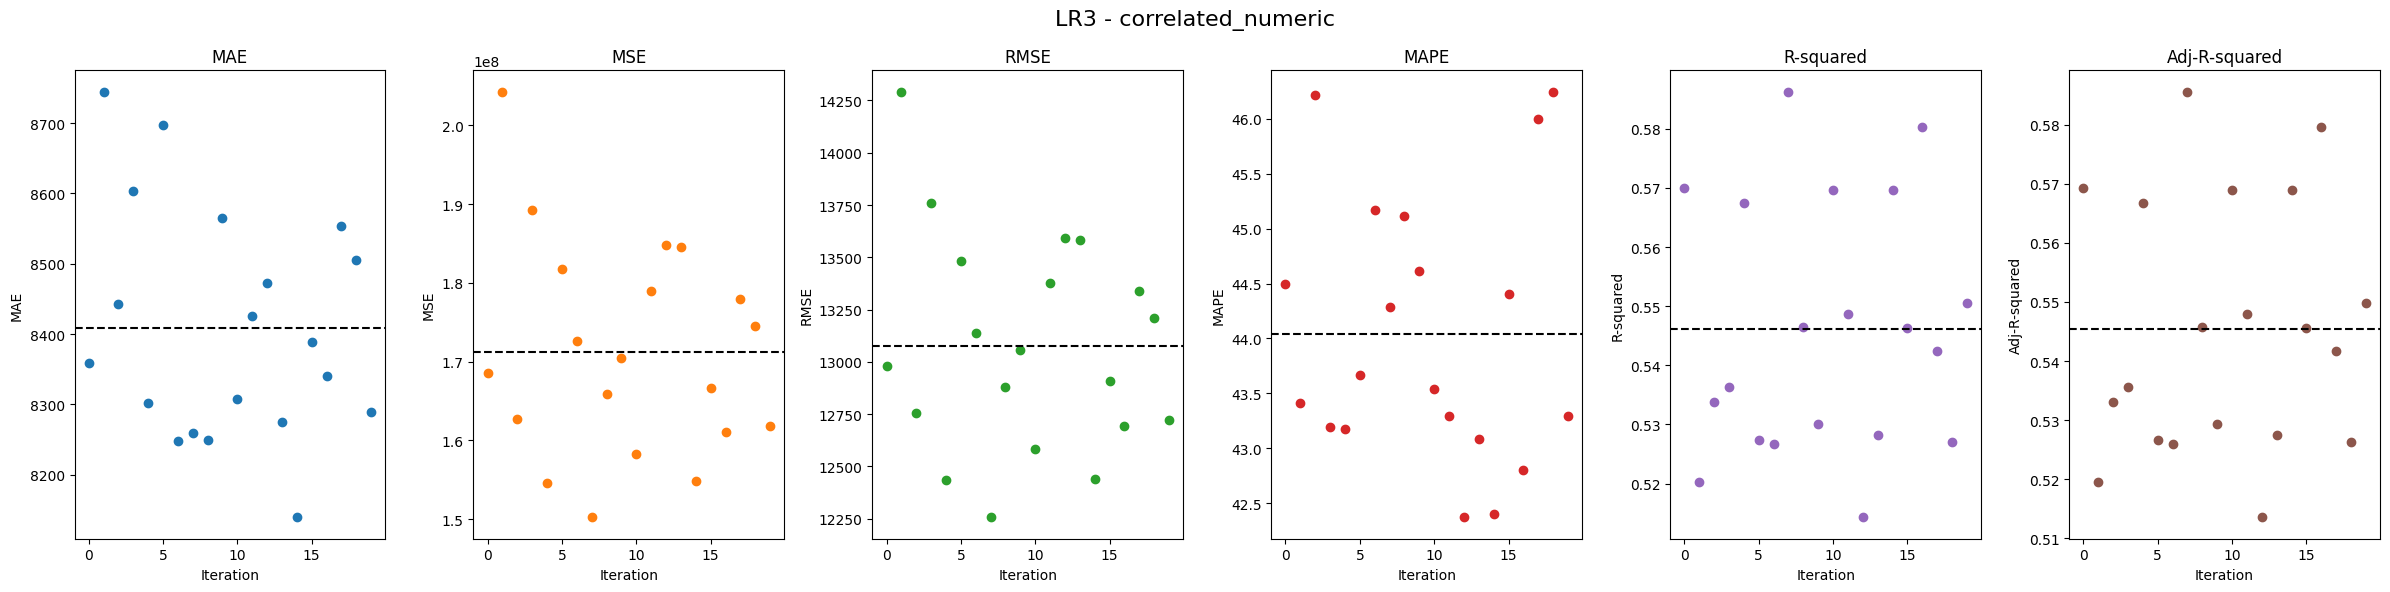

In [59]:
# apply LR model (over loop to generate 100 different models)

model_metrics = []

for i in tqdm(range(n_samples), desc="Model Iterations:"):
    # create a random test-train split
    X = df[["engine_size", "year", "mileage", "feature_4", "feature_5", "feature_6"]]
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # variables
    features = X.columns
    numeric_features = ["engine_size", "year", "mileage"]

    # scale numeric features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train[numeric_features])
    X_test = scaler.fit_transform(X_test[numeric_features])

    # linear regression model
    model = LinearRegression()
    metrics, importances = evaluate_model(
        model,
        features,
        X_train,
        X_test,
        y_train,
        y_test,
        model_type="LR",
        model_variant="3",
        model_description="correlated_numeric",
        print_metrics=False,
        return_importance=False,
    )

    model_metrics.append(metrics)

# plot and generate average metrics
df_model_metrics = pd.DataFrame(model_metrics)
df_model = generate_plot(df_model_metrics, df_model_metrics["Model-Desc"].unique()[0])
df_metrics = pd.concat([df_metrics, df_model])

#### Model4 - LR (all numerical variables)


Model Iterations:: 100%|██████████| 20/20 [00:00<00:00, 179.21it/s]



Metric               Value     
------------------------------
MAE                 : 8444.713
MSE                 : 170757631.458
RMSE                : 13054.103
MAPE                : 44.692
R-squared           : 0.546
Adj-R-squared       : 0.545


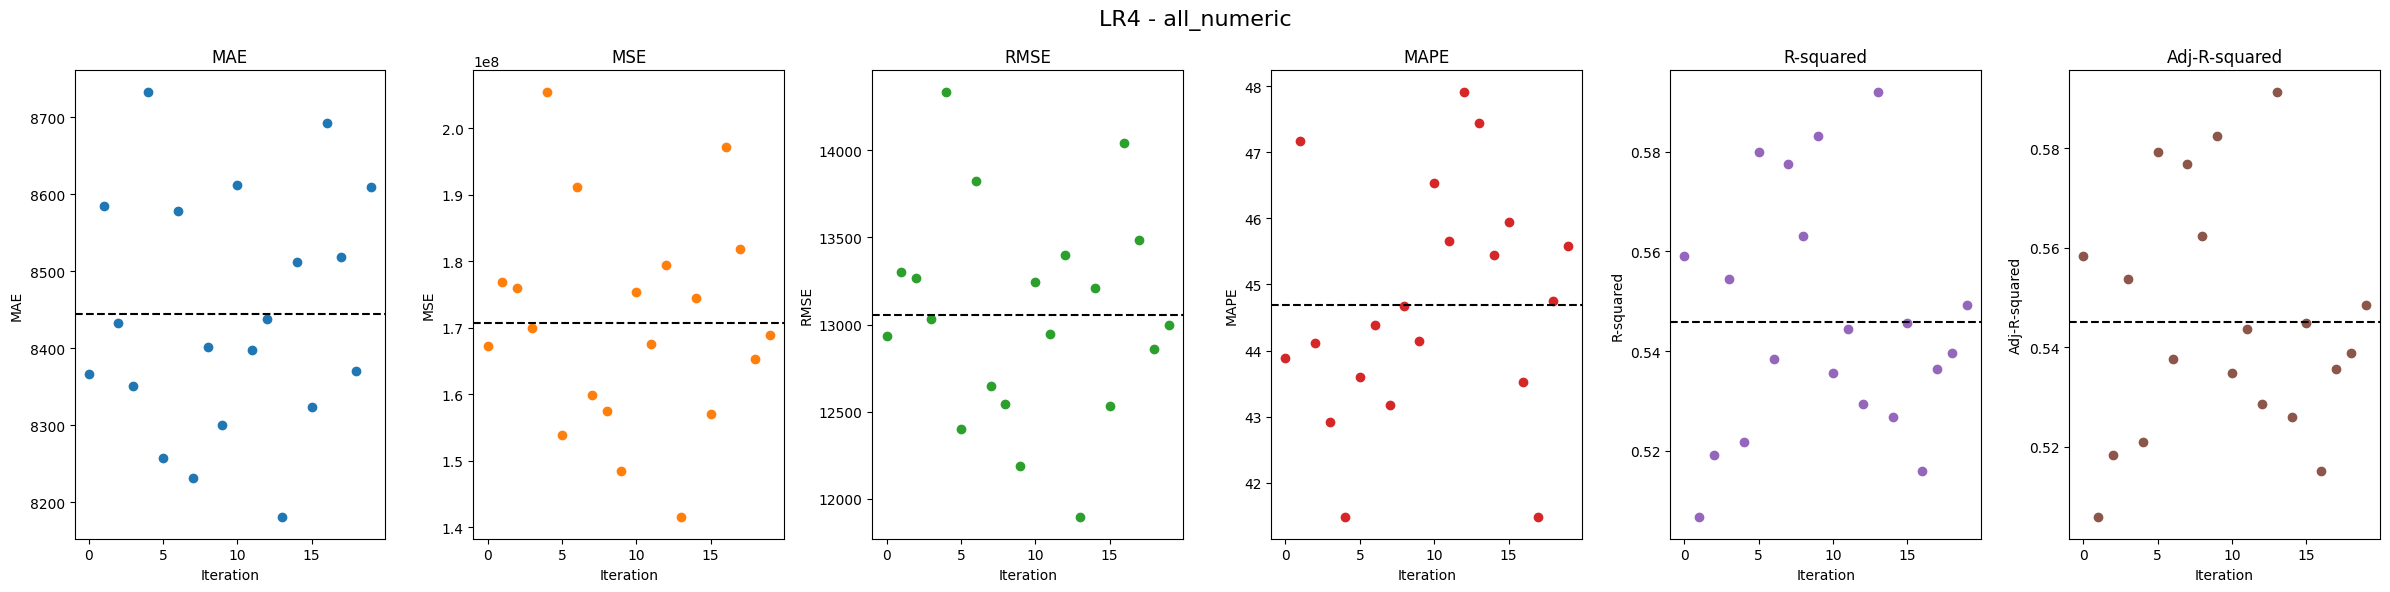

In [60]:
# apply LR model (over loop to generate 100 different models)

model_metrics = []

for i in tqdm(range(n_samples), desc="Model Iterations:"):
    # create a random test-train split
    X = df[
        [
            "engine_size",
            "year",
            "mileage",
            "feature_1",
            "feature_2",
            "feature_3",
            "feature_4",
            "feature_5",
            "feature_6",
            "feature_7",
            "feature_8",
            "feature_9",
            "feature_10",
        ]
    ]
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # variables
    features = X.columns
    numeric_features = ["engine_size", "year", "mileage"]

    # scale numeric features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train[numeric_features])
    X_test = scaler.fit_transform(X_test[numeric_features])

    # linear regression model
    model = LinearRegression()
    metrics, importances = evaluate_model(
        model,
        features,
        X_train,
        X_test,
        y_train,
        y_test,
        model_type="LR",
        model_variant="4",
        model_description="all_numeric",
        print_metrics=False,
        return_importance=False,
    )

    model_metrics.append(metrics)

# plot and generate average metrics
df_model_metrics = pd.DataFrame(model_metrics)
df_model = generate_plot(df_model_metrics, df_model_metrics["Model-Desc"].unique()[0])
df_metrics = pd.concat([df_metrics, df_model])

#### Model5 - LR (all variables - categorical variables mixed encoded)

From the EDA, we know all vehciles are the same `make` so this can be dropped from the dataset. Meanwhile:
- `model` has 58 variants
- `body_type` has 8 variants
- `fuel_type` has 7 variants
- `transmission` has 3 variants
- `colour` has 15 variants
- `area` has 115 variants

Use mixed encoding technique:
- use one-hot encoding for low variant variables (`body_type`, `fuel_type`, `transmission`)
- use target encoding for high-cardinality columns
    - replaces each category with a statistic (e.g., mean, median) of the target variable (price) within that category.

##### !!! Mixed Encoding !!!

In [61]:
df_ = df.drop(["make"], axis=1)

# define column encoding
onehot_encode_columns = ["body_type", "fuel_type", "transmission"]
target_encode_columns = ["model", "colour", "area"]

# one-hot encode
df_encoded_mixed = pd.get_dummies(df_, columns=onehot_encode_columns)
## convert one-hot encoded columns to binary (1/0)
for col in df_encoded_mixed.columns:
    for colx in onehot_encode_columns:
        if colx in col:
            df_encoded_mixed[col] = df_encoded_mixed[col].astype(int)

# target encode
target_encoder = ce.TargetEncoder(cols=target_encode_columns)
df_encoded_mixed = target_encoder.fit_transform(
    df_encoded_mixed, df_encoded_mixed["price"]
)

# dimensions
print(df_encoded_mixed.shape)
df_encoded_mixed.head()

(9522, 35)


,model,engine_size,year,mileage,price,colour,area,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,body_type_Convertible,body_type_Coupe,body_type_Estate,body_type_Hatchback,body_type_MPV,body_type_SUV,body_type_Saloon,body_type_Unlisted,fuel_type_Diesel,fuel_type_Diesel Hybrid,fuel_type_Electric,fuel_type_Petrol,fuel_type_Petrol Hybrid,fuel_type_Petrol Plug-in Hybrid,fuel_type_Unlisted,transmission_Automatic,transmission_Manual,transmission_Unlisted
0,18746.713333,2.0,2021.0,13434,32000,26772.428191,20058.989169,1,1,1,0,1,1,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
1,33515.118361,1.5,2021.0,6347,32898,26772.428191,35618.577868,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
2,33515.118361,1.5,2021.0,10,35510,26772.428191,18750.370787,1,1,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,26799.032368,2.0,2022.0,6500,37999,30217.268641,25452.146019,1,1,1,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,16378.357724,2.0,2012.0,136952,4890,27543.439768,30553.387754,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0


Model Iterations:: 100%|██████████| 20/20 [00:00<00:00, 143.83it/s]


Metric               Value     
------------------------------
MAE                 : 5923.845
MSE                 : 84557806.330
RMSE                : 9183.766
MAPE                : 33.463
R-squared           : 0.778
Adj-R-squared       : 0.777


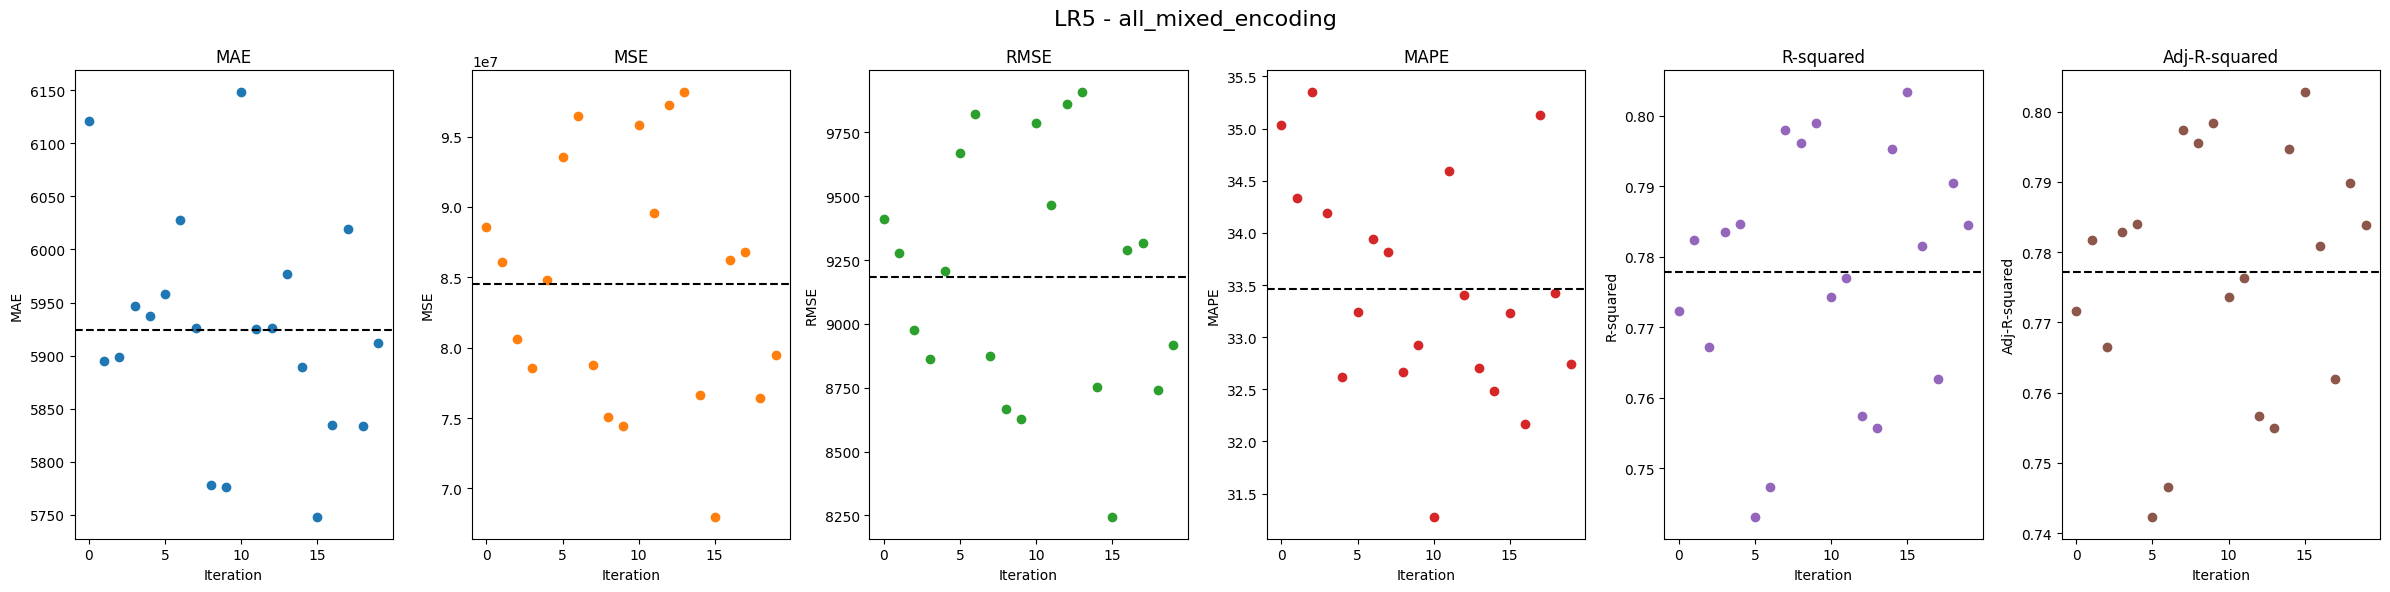

In [62]:
# apply LR model (over loop to generate 100 different models)

model_metrics = []

for i in tqdm(range(n_samples), desc="Model Iterations:"):
    # create a random test-train split
    X = df_encoded_mixed.drop(columns=["price"], axis=1)
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # variables
    features = X.columns
    numeric_features = ["model", "engine_size", "year", "mileage", "colour", "area"]

    # scale numeric features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train[numeric_features])
    X_test = scaler.fit_transform(X_test[numeric_features])

    # linear regression model
    model = LinearRegression()
    metrics, importances = evaluate_model(
        model,
        features,
        X_train,
        X_test,
        y_train,
        y_test,
        model_type="LR",
        model_variant="5",
        model_description="all_mixed_encoding",
        print_metrics=False,
        return_importance=False,
    )

    model_metrics.append(metrics)

# plot and generate average metrics
df_model_metrics = pd.DataFrame(model_metrics)
df_model = generate_plot(df_model_metrics, df_model_metrics["Model-Desc"].unique()[0])
df_metrics = pd.concat([df_metrics, df_model])

#### Model6 - LR (all variables - categorical variables target encoded)

##### !!! Targed Encoding !!!

In [63]:
# target encoding

df_ = df.drop(["make"], axis=1)

# define column encoding
target_encode_columns = [
    "model",
    "colour",
    "area",
    "body_type",
    "fuel_type",
    "transmission",
]

# target encode
target_encoder = ce.TargetEncoder(cols=target_encode_columns)
df_encoded_target = target_encoder.fit_transform(df_, df_["price"])

# dimensions
print(df_encoded_target.shape)
df_encoded_target.head()

(9522, 20)


,model,body_type,fuel_type,engine_size,transmission,year,mileage,price,colour,area,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10
0,18746.713333,36917.730867,30126.084090,2.0,29911.183113,2021.0,13434,32000,26772.428191,20058.989169,1,1,1,0,1,1,0,1,1,1
1,33515.118361,25780.601498,30126.084090,1.5,29911.183113,2021.0,6347,32898,26772.428191,35618.577868,1,0,1,0,0,0,1,0,0,0
2,33515.118361,25780.601498,30126.084090,1.5,12759.030033,2021.0,10,35510,26772.428191,18750.370787,1,1,1,0,1,0,1,1,0,0
3,26799.032368,28897.715441,48817.767318,2.0,29911.183113,2022.0,6500,37999,30217.268641,25452.146019,1,1,1,0,1,1,1,0,0,0
4,16378.357724,19558.041931,17878.120375,2.0,12759.030033,2012.0,136952,4890,27543.439768,30553.387754,0,0,0,0,0,0,0,0,0,0


Model Iterations:: 100%|██████████| 20/20 [00:00<00:00, 135.55it/s]


Metric               Value     
------------------------------
MAE                 : 5575.811
MSE                 : 80077295.463
RMSE                : 8926.109
MAPE                : 30.297
R-squared           : 0.790
Adj-R-squared       : 0.789


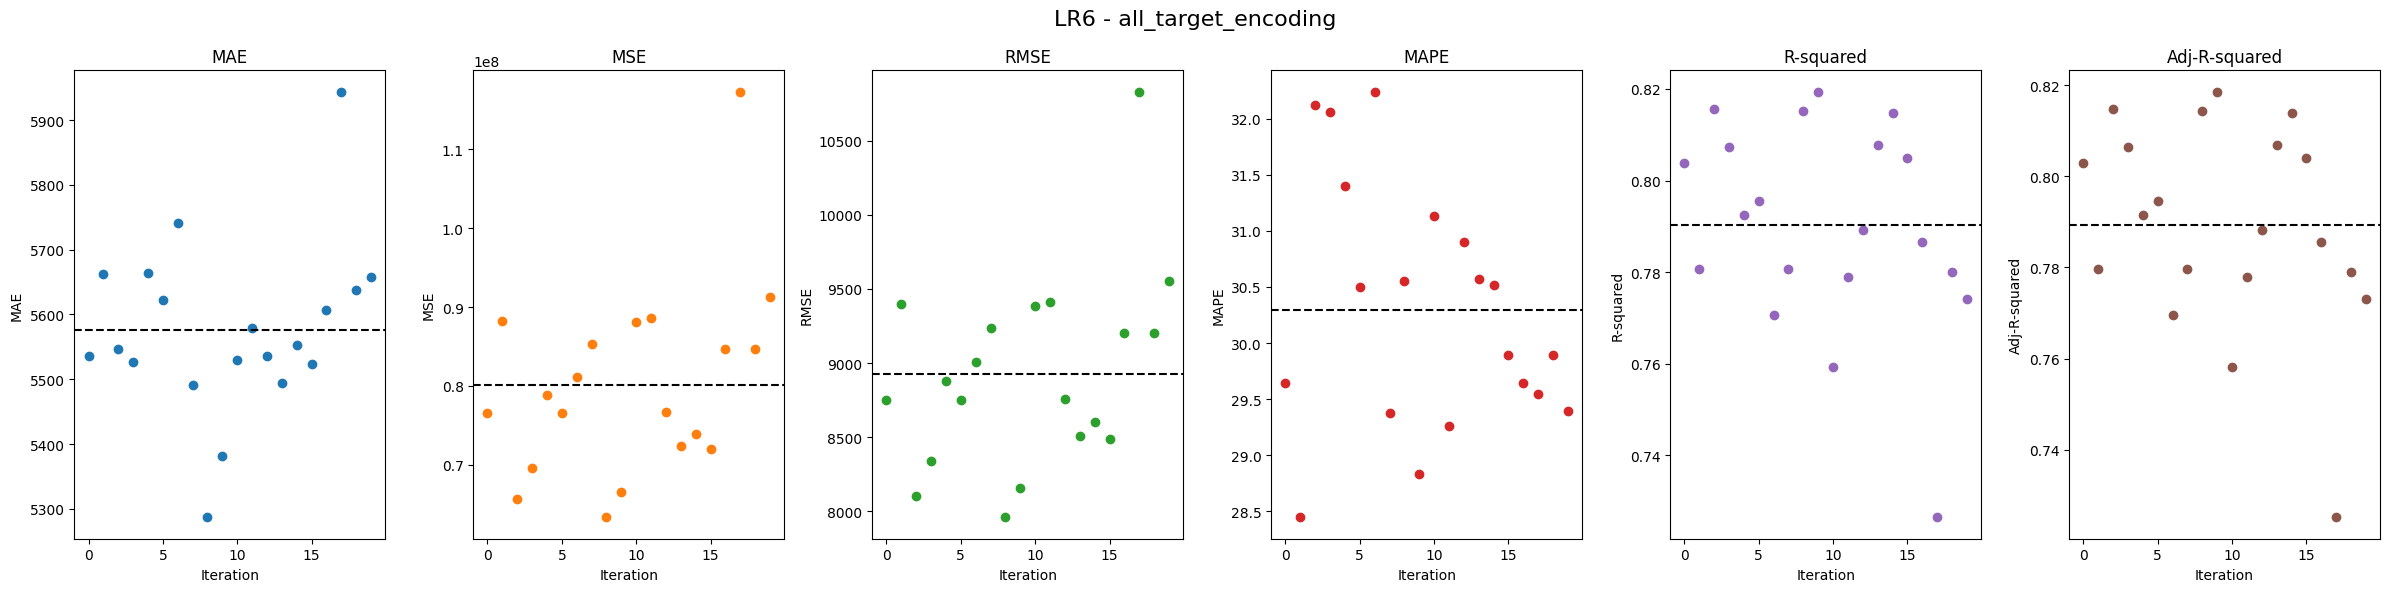

In [64]:
# apply LR model (over loop to generate 100 different models)

model_metrics = []

for i in tqdm(range(n_samples), desc="Model Iterations:"):
    # create a random test-train split
    X = df_encoded_target.drop(columns=["price"], axis=1)
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # variables
    features = X.columns
    numeric_features = [
        "model",
        "engine_size",
        "year",
        "mileage",
        "colour",
        "area",
        "body_type",
        "fuel_type",
        "transmission",
    ]

    # scale numeric features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train[numeric_features])
    X_test = scaler.fit_transform(X_test[numeric_features])

    # linear regression model
    model = LinearRegression()
    metrics, importances = evaluate_model(
        model,
        features,
        X_train,
        X_test,
        y_train,
        y_test,
        model_type="LR",
        model_variant="6",
        model_description="all_target_encoding",
        print_metrics=False,
        return_importance=False,
    )

    model_metrics.append(metrics)

# plot and generate average metrics
df_model_metrics = pd.DataFrame(model_metrics)
df_model = generate_plot(df_model_metrics, df_model_metrics["Model-Desc"].unique()[0])
df_metrics = pd.concat([df_metrics, df_model])

### Gradient Boosting (GB)

#### Model5 – GB (all variables - categorical variables mixed encoded)


Model Iterations:: 100%|██████████| 20/20 [00:11<00:00,  1.74it/s]



Metric               Value     
------------------------------
MAE                 : 3309.411
MSE                 : 38099044.392
RMSE                : 6145.897
MAPE                : 14.148
R-squared           : 0.898
Adj-R-squared       : 0.897


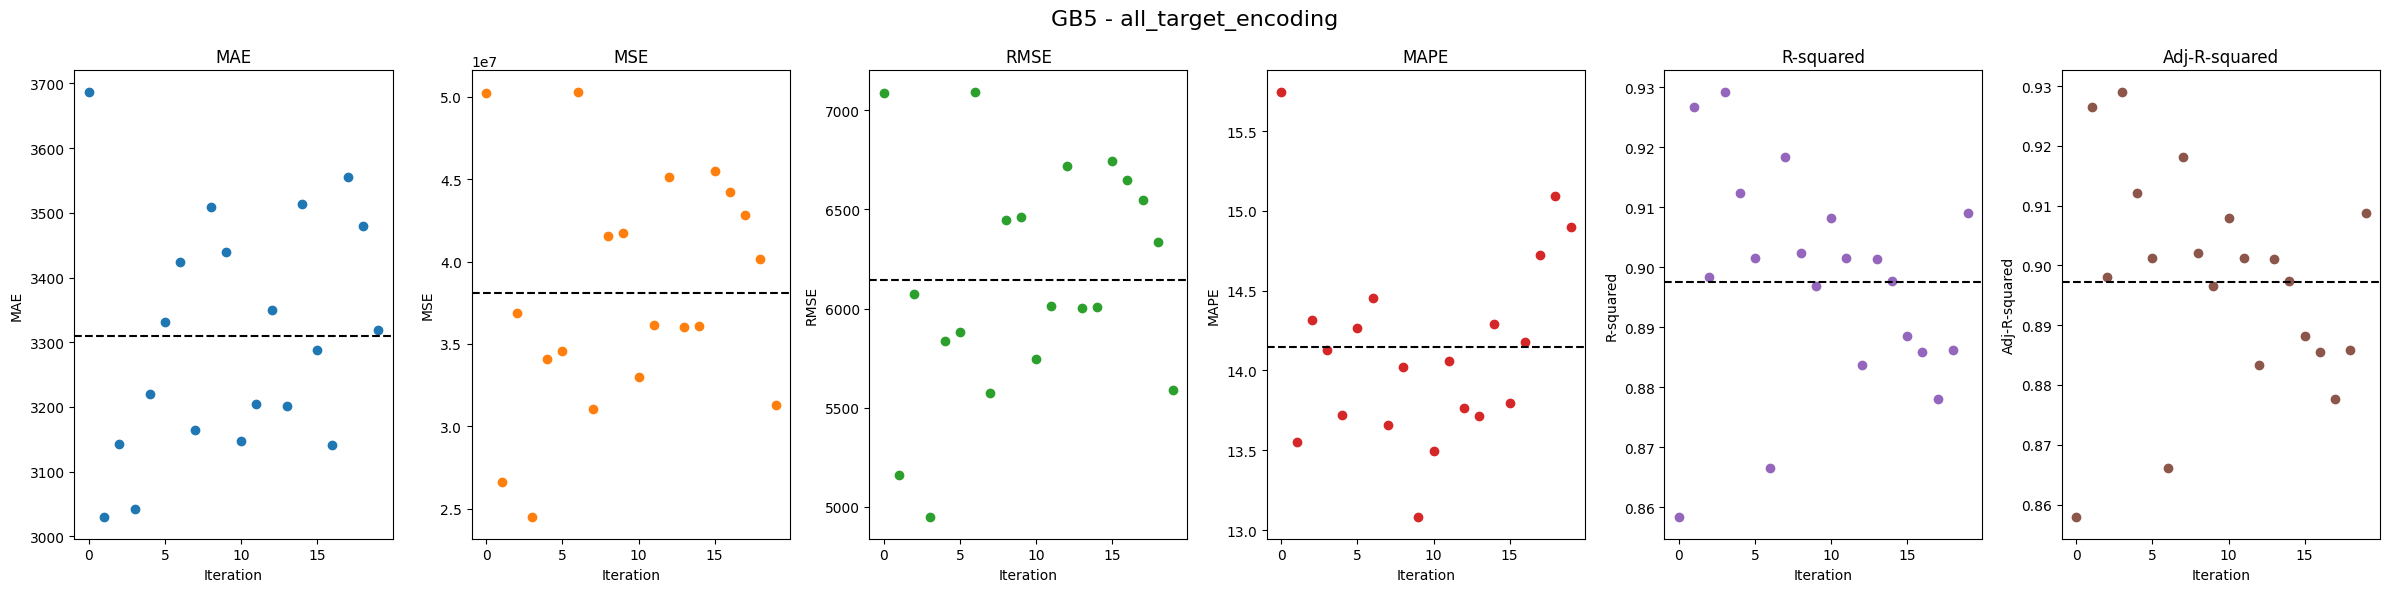

In [65]:
# apply LR model (over loop to generate 100 different models)

model_metrics = []

for i in tqdm(range(n_samples), desc="Model Iterations:"):
    # create a random test-train split
    X = df_encoded_mixed.drop(columns=["price"], axis=1)
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # variables
    features = X.columns
    numeric_features = ["model", "engine_size", "year", "mileage", "colour", "area"]

    # scale numeric features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train[numeric_features])
    X_test = scaler.fit_transform(X_test[numeric_features])

    # gradient boosting model
    model = GradientBoostingRegressor()
    metrics, importances = evaluate_model(
        model,
        features,
        X_train,
        X_test,
        y_train,
        y_test,
        model_type="GB",
        model_variant="5",
        model_description="all_target_encoding",
        print_metrics=False,
        return_importance=False,
    )

    model_metrics.append(metrics)

# plot and generate average metrics
df_model_metrics = pd.DataFrame(model_metrics)
df_model = generate_plot(df_model_metrics, df_model_metrics["Model-Desc"].unique()[0])
df_metrics = pd.concat([df_metrics, df_model])

#### Model6 - GB (all variables - categorical variables target encoded)

Model Iterations:: 100%|██████████| 20/20 [00:12<00:00,  1.54it/s]



Metric               Value     
------------------------------
MAE                 : 3333.645
MSE                 : 40368202.845
RMSE                : 6237.332
MAPE                : 14.374
R-squared           : 0.894
Adj-R-squared       : 0.894


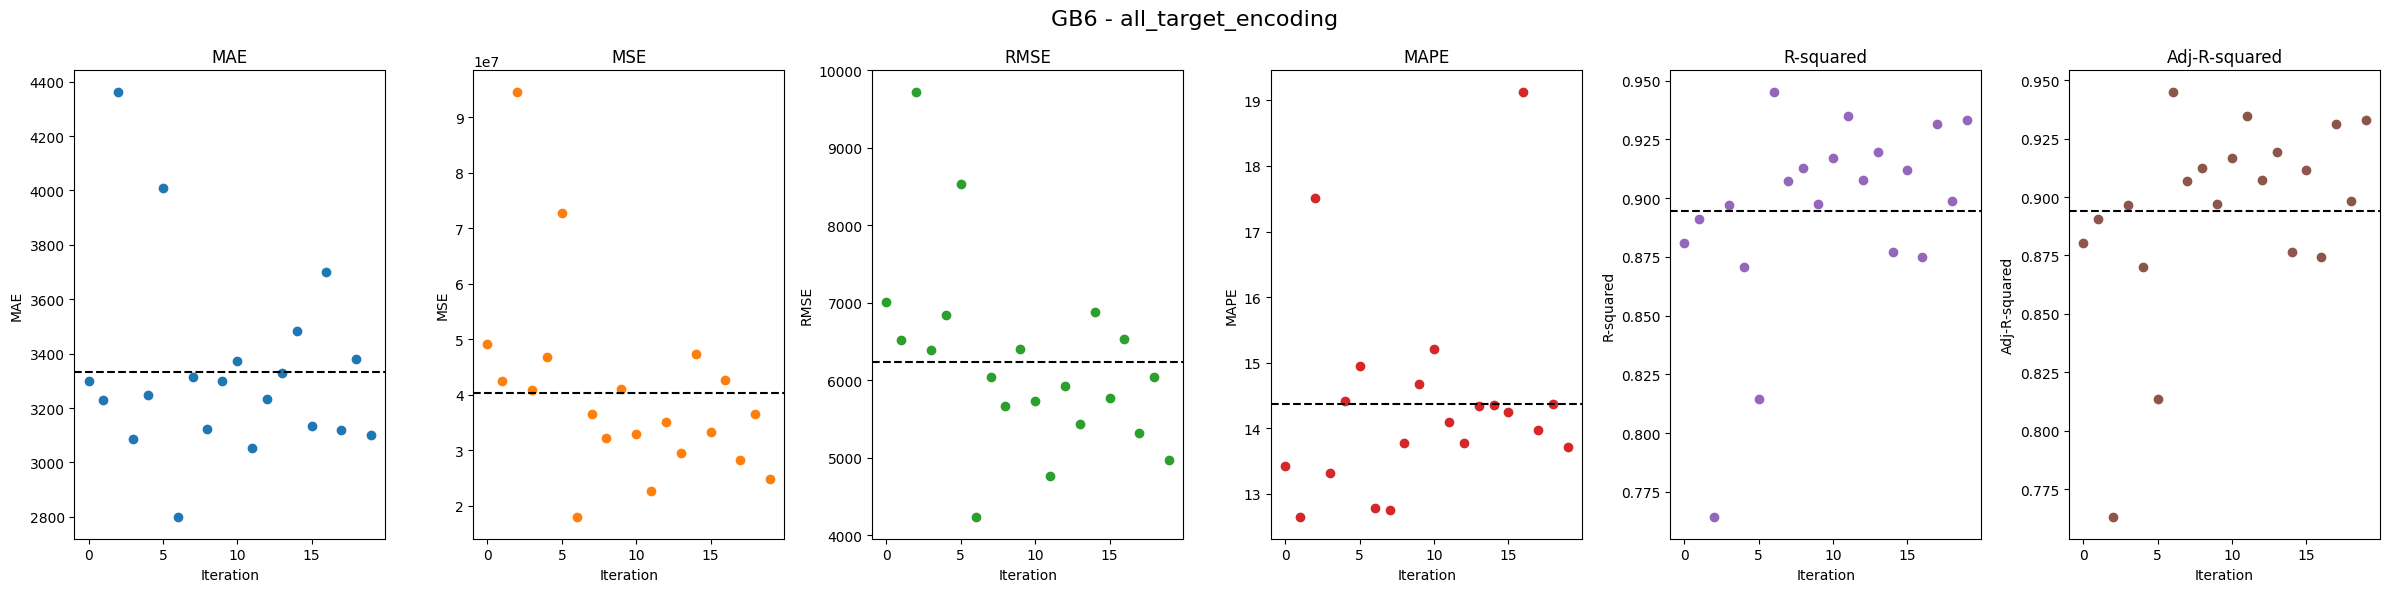

In [66]:
# apply RF model (over loop to generate 100 different models)

model_metrics = []

for i in tqdm(range(n_samples), desc="Model Iterations:"):
    # create a random test-train split
    X = df_encoded_target.drop(columns=["price"], axis=1)
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # variables
    features = X.columns
    numeric_features = [
        "model",
        "engine_size",
        "year",
        "mileage",
        "colour",
        "area",
        "body_type",
        "fuel_type",
        "transmission",
    ]

    # scale numeric features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train[numeric_features])
    X_test = scaler.fit_transform(X_test[numeric_features])

    # gradient boosting model
    model = GradientBoostingRegressor()
    metrics, importances = evaluate_model(
        model,
        features,
        X_train,
        X_test,
        y_train,
        y_test,
        model_type="GB",
        model_variant="6",
        model_description="all_target_encoding",
        print_metrics=False,
        return_importance=False,
    )

    model_metrics.append(metrics)

# plot and generate average metrics
df_model_metrics = pd.DataFrame(model_metrics)
df_model = generate_plot(df_model_metrics, df_model_metrics["Model-Desc"].unique()[0])
df_metrics = pd.concat([df_metrics, df_model])

### Random Forest (RF)

#### Model5 - RF (all variables - categorical variables mixed encoded)

Model Iterations:: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it]



Metric               Value     
------------------------------
MAE                 : 2283.292
MSE                 : 22569925.673
RMSE                : 4693.793
MAPE                : 9.781
R-squared           : 0.941
Adj-R-squared       : 0.940


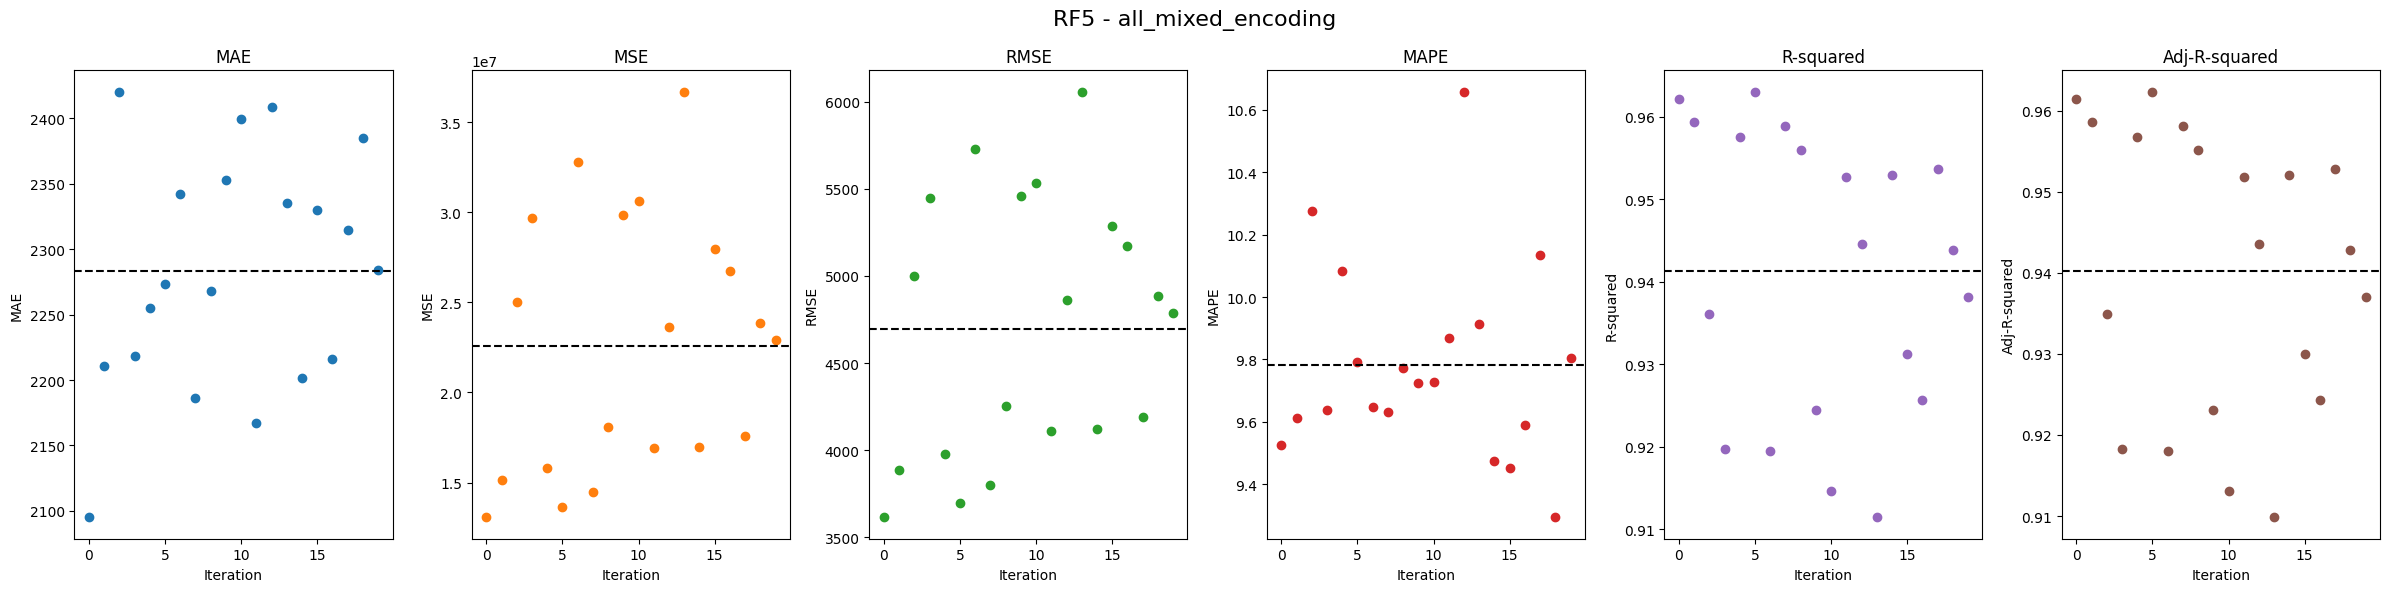

In [67]:
# apply RF model (over loop to generate 100 different models)

model_metrics = []

for i in tqdm(range(n_samples), desc="Model Iterations:"):
    # create a random test-train split
    X = df_encoded_mixed.drop(columns=["price"], axis=1)
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # variables
    features = X.columns
    numeric_features = ["model", "engine_size", "year", "mileage", "colour", "area"]

    # linear regression model
    model = RandomForestRegressor()
    metrics, importances = evaluate_model(
        model,
        features,
        X_train,
        X_test,
        y_train,
        y_test,
        model_type="RF",
        model_variant="5",
        model_description="all_mixed_encoding",
        print_metrics=False,
        return_importance=False,
    )

    model_metrics.append(metrics)

# plot and generate average metrics
df_model_metrics = pd.DataFrame(model_metrics)
df_model = generate_plot(df_model_metrics, df_model_metrics["Model-Desc"].unique()[0])
df_metrics = pd.concat([df_metrics, df_model])

#### Model6 - RF (all variables - categorical variables target encoded)

Model Iterations:: 100%|██████████| 20/20 [00:54<00:00,  2.74s/it]



Metric               Value     
------------------------------
MAE                 : 2298.767
MSE                 : 24630282.679
RMSE                : 4895.600
MAPE                : 9.808
R-squared           : 0.935
Adj-R-squared       : 0.935


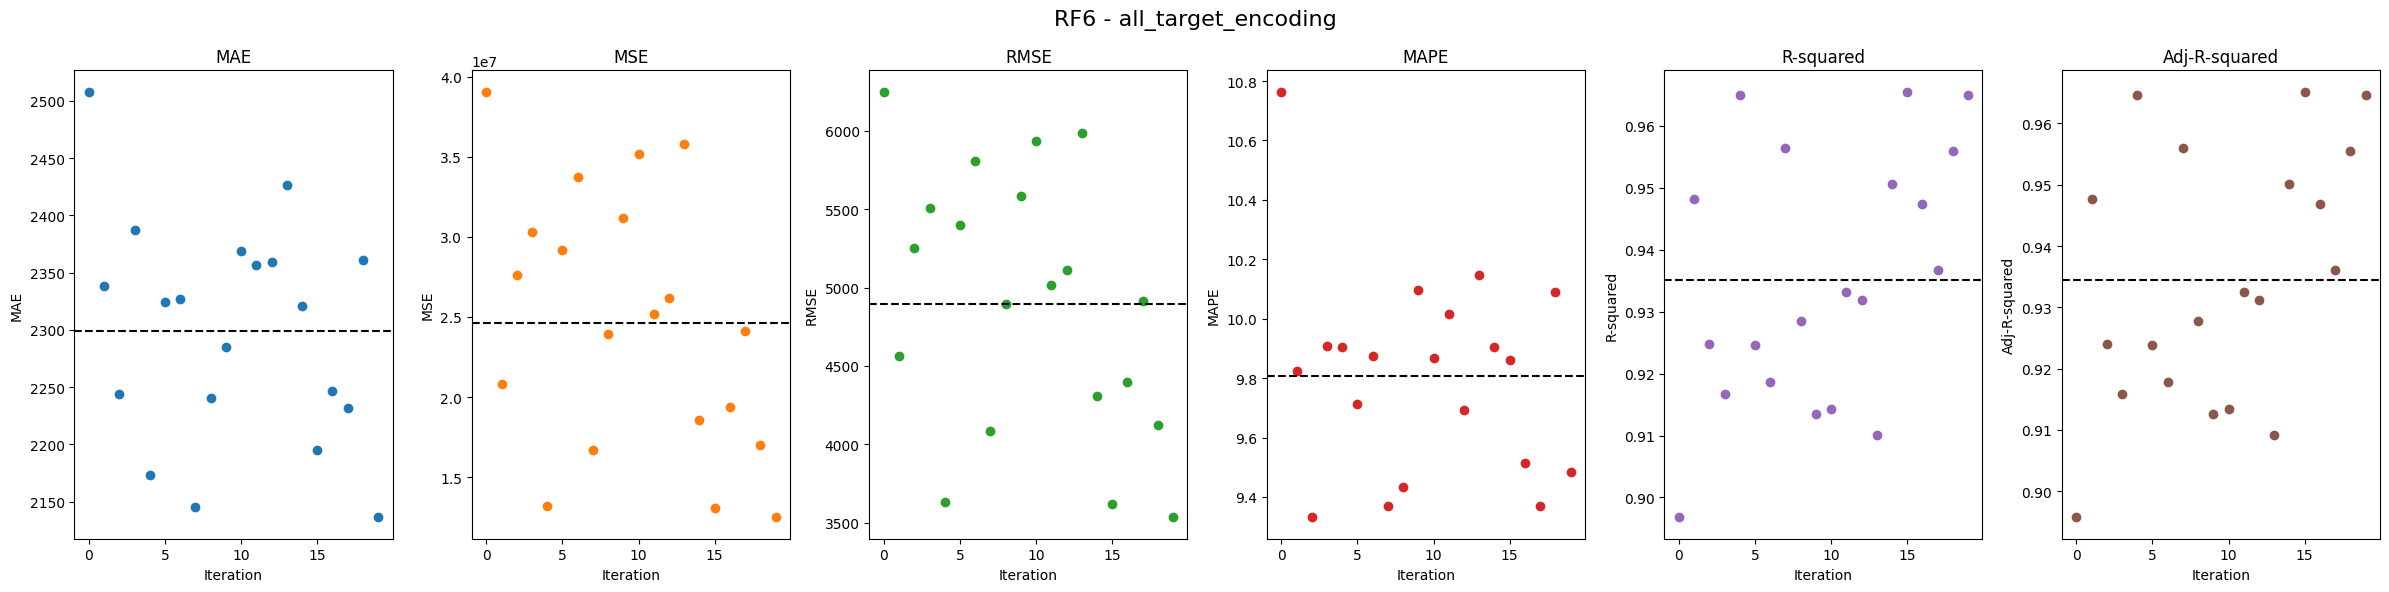

In [68]:
# apply RF model (over loop to generate 100 different models)

model_metrics = []

for i in tqdm(range(n_samples), desc="Model Iterations:"):
    # create a random test-train split
    X = df_encoded_target.drop(columns=["price"], axis=1)
    y = df["price"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # variables
    features = X.columns
    numeric_features = [
        "model",
        "engine_size",
        "year",
        "mileage",
        "colour",
        "area",
        "body_type",
        "fuel_type",
        "transmission",
    ]

    # linear regression model
    model = RandomForestRegressor()
    metrics, importances = evaluate_model(
        model,
        features,
        X_train,
        X_test,
        y_train,
        y_test,
        model_type="RF",
        model_variant="6",
        model_description="all_target_encoding",
        print_metrics=False,
        return_importance=False,
    )

    model_metrics.append(metrics)

# plot and generate average metrics
df_model_metrics = pd.DataFrame(model_metrics)
df_model = generate_plot(df_model_metrics, df_model_metrics["Model-Desc"].unique()[0])
df_metrics = pd.concat([df_metrics, df_model])

##### Feature Importance


In [125]:
# create a random test-train split
X = df_encoded_target.drop(columns=["price"], axis=1)
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# variables
features = X.columns
numeric_features = [
    "model",
    "engine_size",
    "year",
    "mileage",
    "colour",
    "area",
    "body_type",
    "fuel_type",
    "transmission",
]

# linear regression model
output_model = RandomForestRegressor()
metrics, importances = evaluate_model(
    output_model,
    features,
    X_train,
    X_test,
    y_train,
    y_test,
    model_type="RF",
    model_variant="6",
    model_description="all_target_encoding",
    print_metrics=False,
    return_importance=True,
)


Metric                                   Importance
--------------------------------------------------
model                                   : 0.2886
body_type                               : 0.0070
fuel_type                               : 0.0052
engine_size                             : 0.0498
transmission                            : 0.0073
year                                    : 0.1435
mileage                                 : 0.4735
colour                                  : 0.0060
area                                    : 0.0064
feature_1                               : 0.0009
feature_2                               : 0.0014
feature_3                               : 0.0012
feature_4                               : 0.0024
feature_5                               : 0.0012
feature_6                               : 0.0010
feature_7                               : 0.0010
feature_8                               : 0.0002
feature_9                               : 0.0024
feature_10    

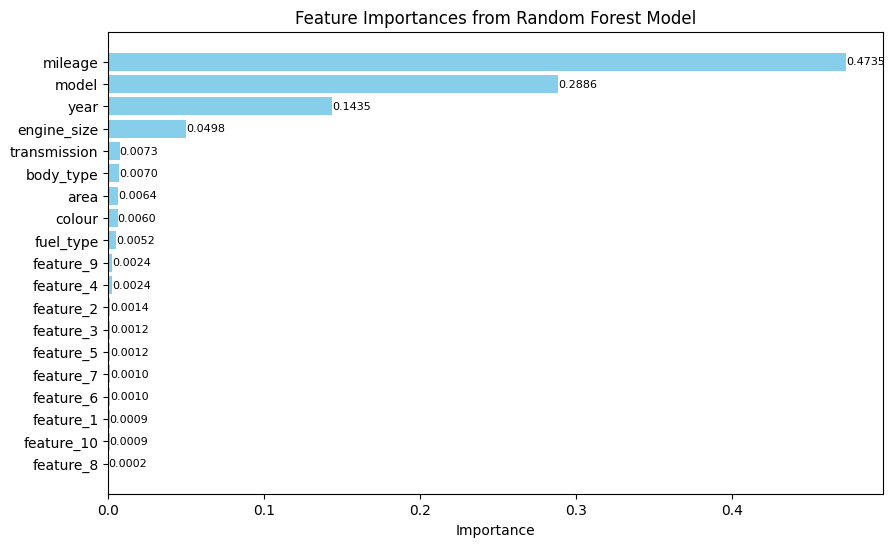

In [126]:
# Sort the DataFrame by importance
importance_df = pd.DataFrame(importances).sort_values(by="Importance", ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 6))
bars = plt.barh(importance_df["Variable"], importance_df["Importance"], color="skyblue")

# Adding value annotations to the end of each bar
for bar in bars:
    plt.text(
        bar.get_width(),
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.4f}",
        va="center",
        ha="left",
        size=8,
    )

plt.xlabel("Importance")
plt.title("Feature Importances from Random Forest Model")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature on top
plt.show()

- perhaps features with low importance (< 0.01) should be dropped before hyperparameter tuning
- in this case, the model build time is not too long, therefore we can retain all features, even if they only add partial information!

##### Feature_X Permutation

- make permutations in `feature_` columns to understand impact on model performance (i.e. column by column, change `feature_` values and examine the impact on performance when predicting price)

In [127]:
# Specify the columns to permute (e.g., columns named feature_X1 to feature_X10)
columns_to_permute = [col for col in X_test.columns if "feature_" in col]

permuted_mse_list = []
# Run the permutation process n_sample times
for i in range(n_samples):
    X_test_permuted = X_test.copy()

    # Shuffle the selected columns for this iteration
    for col in columns_to_permute:
        X_test_permuted[col] = np.random.permutation(X_test_permuted[col].values)

        # Evaluate the model after permutation
        y_pred_permuted = output_model.predict(X_test_permuted)
        permuted_mse = mean_squared_error(y_test, y_pred_permuted)

        # Store the permuted MSE in the list
        permuted_mse_list.append({"feature": col, "mse": permuted_mse})

        # reset
        X_test_permuted = X_test.copy()

df_permuted_mse = pd.DataFrame(permuted_mse_list)

In [128]:
df_permuted_mse_totals = (
    df_permuted_mse.groupby(["feature"])
    .agg(mean_mse=("mse", "mean"), std_mse=("mse", "sum"))
    .reset_index()
)

df_permuted_mse_totals["delta"] = df_permuted_mse_totals["mean_mse"] - metrics["MSE"]
df_permuted_mse_totals["delta_percentage"] = (
    100 * df_permuted_mse_totals["delta"] / metrics["MSE"]
)

df_permuted_mse_totals.sort_values(["delta_percentage"], ascending=False)

,feature,mean_mse,std_mse,delta,delta_percentage
9,feature_9,2.314129e+07,4.628259e+08,1.877689e+06,8.830529
4,feature_4,2.167796e+07,4.335591e+08,4.143493e+05,1.948631
3,feature_3,2.157577e+07,4.315155e+08,3.121675e+05,1.468084
2,feature_2,2.146684e+07,4.293369e+08,2.032380e+05,0.955802
1,feature_10,2.144465e+07,4.288929e+08,1.810402e+05,0.851409
7,feature_7,2.144254e+07,4.288508e+08,1.789342e+05,0.841505
5,feature_5,2.140394e+07,4.280787e+08,1.403306e+05,0.659957
8,feature_8,2.126042e+07,4.252085e+08,-3.182621e+03,-0.014967
6,feature_6,2.125157e+07,4.250313e+08,-1.203953e+04,-0.056620
0,feature_1,2.116459e+07,4.232918e+08,-9.901848e+04,-0.465671


# Compare

Index(['Model', 'Mean Adj-R-squared', 'Mean MAE', 'Mean MAPE', 'Mean MSE',
       'Mean R-squared', 'Mean RMSE', 'Std Adj-R-squared', 'Std MAE',
       'Std MAPE', 'Std MSE', 'Std R-squared', 'Std RMSE'],
      dtype='object')


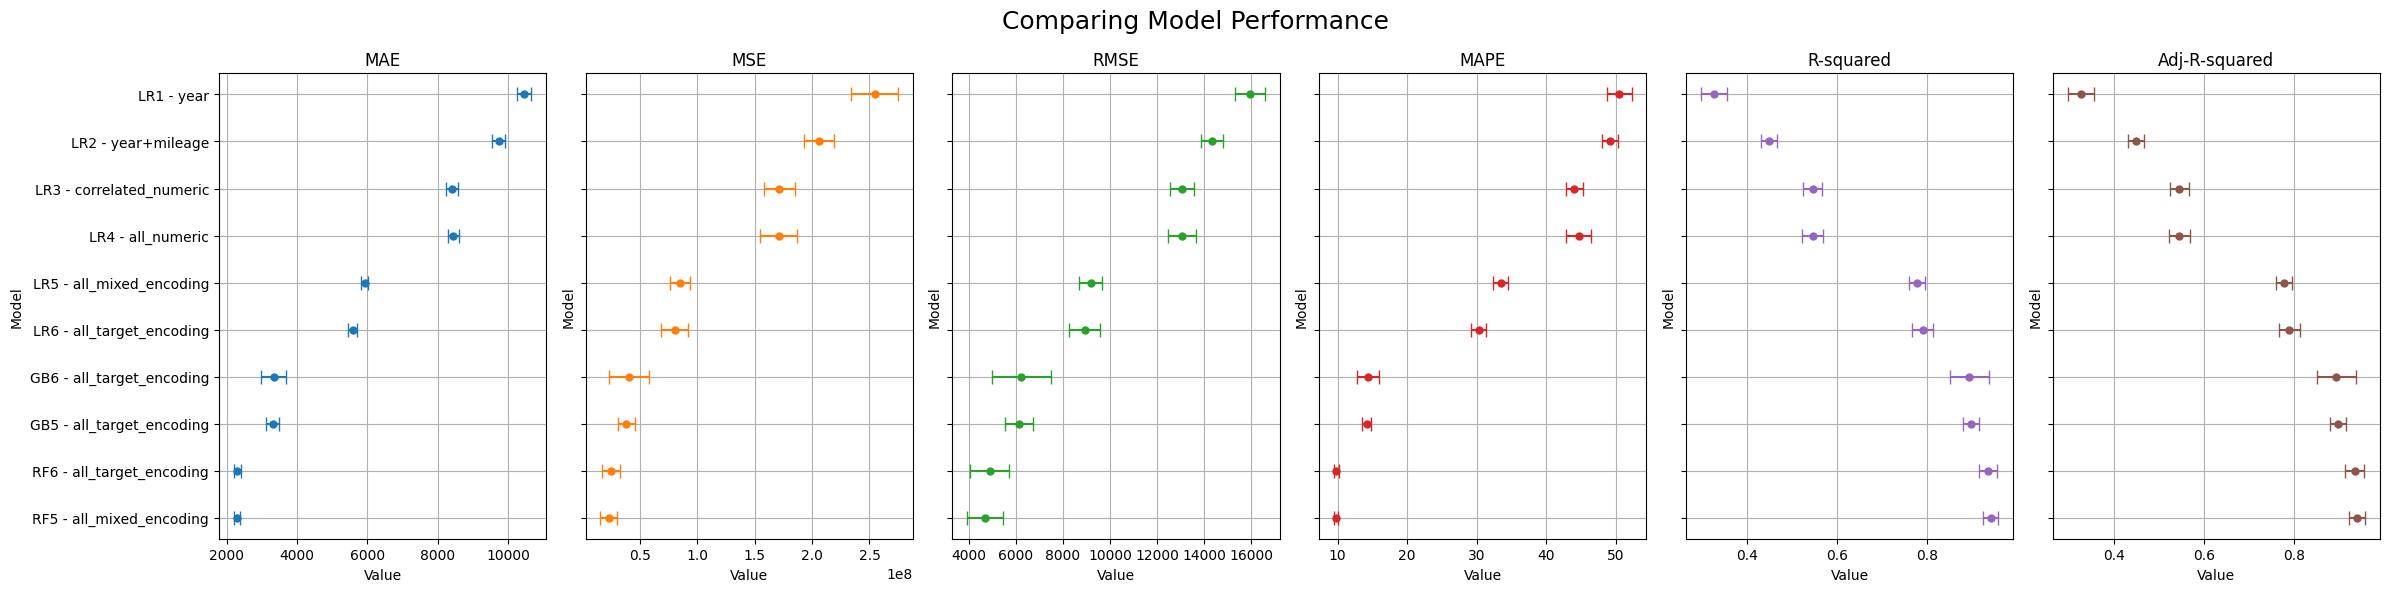

In [129]:
def plot_metrics_with_error_bars(df):
    # Pivot the dataframe to get mean and std for each metric
    pivot_df = df.pivot(
        index="Model", columns="Metric", values=["Mean", "Std"]
    ).reset_index()
    pivot_df.columns = [" ".join(col).strip() for col in pivot_df.columns]
    print(pivot_df.columns)
    pivot_df = pivot_df.sort_values(["Mean MSE"])

    # Define the metrics to plot
    metrics = ["MAE", "MSE", "RMSE", "MAPE", "R-squared", "Adj-R-squared"]

    # Set up the subplot layout
    fig, axes = plt.subplots(1, len(metrics), figsize=(24, 6), sharey=True)

    # Plot each metric
    for i, (ax, metric) in enumerate(zip(axes, metrics)):
        ax.errorbar(
            pivot_df[f"Mean {metric}"],
            pivot_df["Model"],
            xerr=pivot_df[f"Std {metric}"],
            fmt="o",
            label=metric,
            markersize=5,
            capsize=5,
            color=sns.color_palette()[i],
        )
        ax.set_title(metric)
        ax.set_ylabel("Model")  # Y-axis label as 'Model'
        ax.set_xlabel("Value")  # X-axis label as 'Value'
        ax.grid(True)

    plt.suptitle("Comparing Model Performance", size=18)
    plt.tight_layout()
    plt.show()


plot_metrics_with_error_bars(df_metrics)

## Price Position Dimension

- compare residuals of `final_model` with `price_position`

In [218]:
# create a random test-train split
X = df_encoded_target.drop(columns=["price"], axis=1)
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# y_test retains index numbers -> can use index numbers to match with raw `price_position data`

# fit model
output_model.fit(X_train, y_train)

# make predictions
y_pred = output_model.predict(X_test)

In [219]:
# get `price_position` - join y_test with raw data and extract
df_comp = pd.DataFrame(y_test).merge(
    df_in["price_position"], left_index=True, right_index=True
)
df_comp["price_pred"] = y_pred
df_comp["residuals"] = df_comp["price"] - df_comp["price_pred"]

In [235]:
# outliers
df_graph = df_comp[["price_position", "residuals"]]

# outliers - IQR
# Q1 = df_graph.quantile(0.25)
# Q3 = df_graph.quantile(0.75)
# IQR = Q3 - Q1

# # Calculate bounds
# lower_bound = Q1 - (1.5 * IQR)
# upper_bound = Q3 + (1.5 * IQR)

# # Flag outliers
# df_graph['is_outlier_x'] = (df_graph['price_position'] < lower_bound['price_position']) | (df_graph['price_position'] > upper_bound['price_position'])
# df_graph['is_outlier_y'] = (df_graph['residuals'] < lower_bound['residuals']) | (df_graph['residuals'] > upper_bound['residuals'])

# outliers - Z-score
z_scores_x = np.abs(stats.zscore(df_graph["price_position"]))
df_graph["is_outlier_x"] = z_scores_x > 3

z_scores_y = np.abs(stats.zscore(df_graph["residuals"]))
df_graph["is_outlier_y"] = z_scores_y > 3

# outliers!
df_graph["is_outlier"] = np.where(
    df_graph["is_outlier_x"] | df_graph["is_outlier_y"], 1, 0
)

/var/folders/vr/53g6891d1f95k7gpttqp4mvm0000gn/T/ipykernel_98557/1780488413.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['is_outlier_x'] = z_scores_x > 3


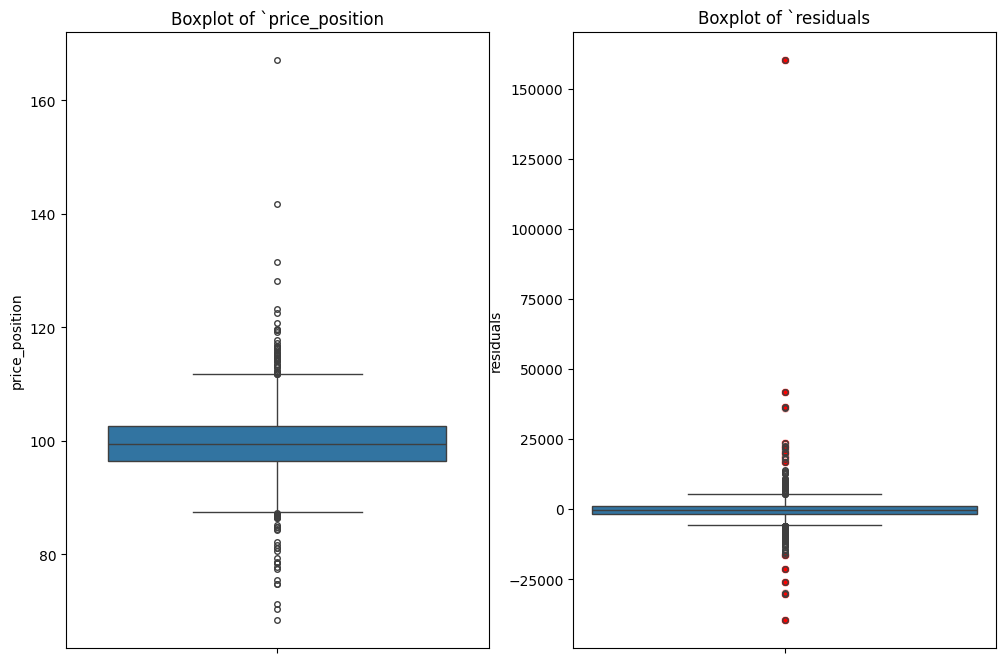

In [239]:
# box and whisker to show distributions and flag outliers
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
n_outliers = df_graph.query("is_outlier_x==True").shape[0]
sns.boxplot(
    df_graph["price_position"], flierprops=dict(marker="o", color="red", markersize=4)
)
sns.scatterplot(
    x=[0] * n_outliers,
    y=df_graph.query("is_outlier_x==True")["price_position"],
    color="red",
)
plt.title("Boxplot of `price_position")

plt.subplot(1, 2, 2)
n_outliers = df_graph.query("is_outlier_y==True").shape[0]
sns.boxplot(
    df_graph["residuals"], flierprops=dict(marker="o", color="red", markersize=4)
)
sns.scatterplot(
    x=[0] * n_outliers, y=df_graph.query("is_outlier_y==True")["residuals"], color="red"
)
plt.title("Boxplot of `residuals")

plt.show()

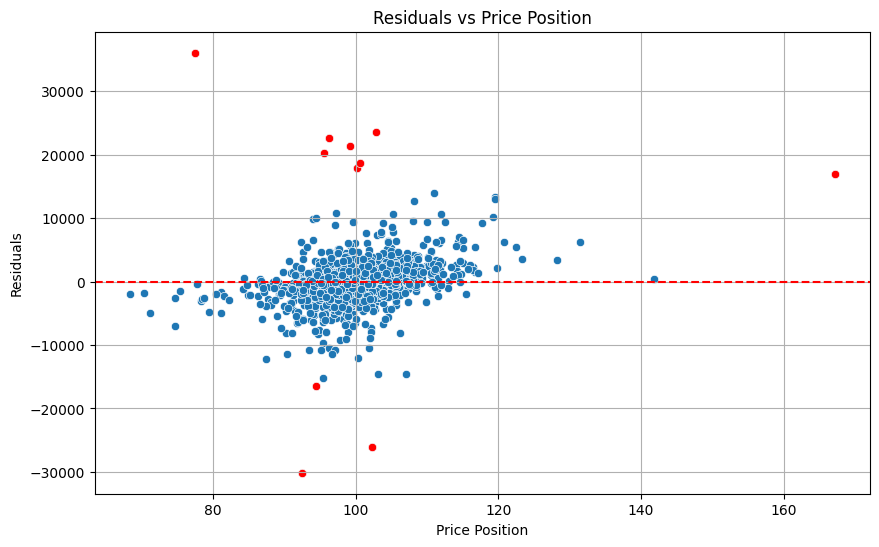

Correlation between residuals and price position                      : 0.33
Correlation between residuals and price position (ignoring outliers)  : 0.40


In [244]:
# plot price_position vs residuals (flagging outliers)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_graph, x="price_position", y="residuals")
sns.scatterplot(
    x=df_graph.query("is_outlier==1")["price_position"],
    y=df_graph.query("is_outlier==1")["residuals"],
    color="red",
)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Price Position")
plt.xlabel("Price Position")
plt.ylabel("Residuals")
plt.grid()
plt.show()

# calculate correlations (with and without outliers)

correlation = df_graph["residuals"].corr(df_graph["price_position"])
print(f'{"Correlation between residuals and price position":<70}: {correlation:.2f}')
correlation = df_graph.query("is_outlier==0")["residuals"].corr(
    df_graph.query("is_outlier==0")["price_position"]
)
print(
    f'{"Correlation between residuals and price position (ignoring outliers)":<70}: {correlation:.2f}'
)

- Positive Correlation:
    - The correlation between residuals and price position is 0.34, which indicates a moderate positive correlation. This suggests that as the price position increases, the residuals tend to become more positive. In other words, the model might be underestimating the prices of vehicles with higher price positions.
- Residual Distribution:
    - Most residuals are centered around zero for the middle range of price positions (around 100), but as the price position moves higher (beyond 120), there seem to be more positive residuals, meaning the model predicts prices that are lower than actual.
    - There are also some vehicles with high residuals (large positive values), especially for higher price positions, which may represent premium vehicles that the model is struggling to price accurately.
- Outliers:
    - There are outliers where residuals are quite large both on the positive and negative side (e.g., residuals above 30,000 or below -20,000). These outliers might represent instances where the model either severely underpredicts or overpredicts price.


Interpretation of Price Position:
- Price Position is likely a measure that compares a vehicle's price relative to others within the dataset or market. It may factor in variables like model, age, and mileage.
- Vehicles with a high price position are priced at a premium relative to others, while those with a low price position are priced more competitively or affordably.

In [248]:
# examine some outliers
outlier_index = df_graph.query("is_outlier==1")

df_in.iloc[outlier_index.index]

,make,model,body_type,fuel_type,engine_size,transmission,year,mileage,price,colour,area,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,price_position
9298,BMW,M3,Convertible,Petrol,3.2,Manual,2004.0,39000,29995,Black,BT,1,0,1,0,1,1,1,0,0,0,NaN
954,BMW,M8,Convertible,Petrol,4.4,Automatic,2021.0,17416,89950,Black,GL,1,0,0,0,1,0,1,0,0,0,99.2
2391,BMW,i8,Convertible,Petrol Plug-in Hybrid,1.5,Automatic,2020.0,10204,72500,Grey,LE,1,1,0,0,0,0,1,0,1,0,95.6
7647,BMW,7 Series,Saloon,Petrol,2.0,Automatic,2020.0,61000,8499,Unknown,SO,1,0,1,0,0,1,1,0,0,0,NaN
6489,BMW,i8,Convertible,Petrol Plug-in Hybrid,1.5,Automatic,2019.0,7000,74990,White,RH,1,1,0,0,0,1,1,0,1,1,102.9
1419,BMW,7 Series,Saloon,Petrol,6.6,Automatic,2019.0,30026,68179,Black,TW,1,1,0,1,1,0,1,1,0,0,96.3
323,BMW,Z8,Convertible,Petrol,4.9,Manual,2014.0,7100,225000,Silver,OX,0,0,0,0,0,1,1,0,0,0,NaN
6042,BMW,M4,Coupe,Petrol,3.0,Automatic,2022.0,100,120000,Unknown,BT,1,0,1,0,1,0,1,0,0,0,77.5
2693,BMW,M3,Coupe,Petrol,3.2,Automatic,2004.0,35100,97500,Silver,OX,0,0,0,0,0,0,0,0,0,0,NaN
5359,BMW,X5,SUV,Diesel Hybrid,3.0,Automatic,2022.0,10,97632,Black,HP,0,0,0,1,0,0,1,0,0,0,NaN


- some outliers at the extremes of mileage (very low)
- other outliers are potentially rare/premium cars with an outlier combination of price, mileage and other features

## TODO

##### Hyperparameter Tune 

- tune the models hyperparameters and cross-validation to determine whether an improved model configuration can be found
    - important parameters:
        - n_estimators: number of trees in the forest - increasing the number of trees can improve performance, but it also increases computational cost and training time.
        - max_features: number of features to consider when looking for the best split - lowering this can reduce overfitting, but too low a value may lead to underfitting
        - maximum depth of each tree - limiting the depth of trees can prevent overfitting, a deeper tree can model more complex relationships but may lead to overfitting
        - min_samples_split: minimum number of samples required to split an internal node - increasing this value can help prevent overfitting by requiring more samples to create a split
        - min_samples_leaf: minimum number of samples required to be at a leaf node - can help prevent overfitting by ensuring that leaf nodes have a minimum number of samples
        - bootstrap: whether bootstrap samples are used when building trees

In [ ]:
from pprint import pprint

# current model parameters - default values
print("Parameters currently in use:\n")
pprint(model.get_params())

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
# Number of features to consider at every split
max_features = [None, "sqrt", "log2"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}

pprint(random_grid)

In [ ]:
# Use the random grid to search for best hyperparameters

# First create the base model to tune
model = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(
    estimator=model,
    param_distributions=random_grid,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

# generate train-test sets, only use important features from previous analysis
X = df_encoded[["mileage", "model", "year", "engine_size"]]
y = df_encoded["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_params_

In [ ]:
# apply RF model (over loop to generate 100 different models)

X = df_encoded[["mileage", "model", "year", "engine_size"]]
y = df_encoded["price"]

model_results = []

for i in tqdm(range(n_samples), desc="tqdm() Progress Bar"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # scaling not required in RF

    # linear regression model
    model = rf_random.best_estimator_

    # fit model
    model.fit(X_train, y_train)

    # make predictions
    y_pred = model.predict(X_test)

    # evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results = {"itr": i, "mse": mse, "r2": r2}

    if r2 < 0:
        break

    model_results.append(results)

df_model_results = pd.DataFrame(model_results)

# plot results
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# averages
mean_mse = df_model_results["mse"].mean()
mean_r2 = df_model_results["r2"].mean()
print(f"Mean Squared Error: {mean_mse:.0f}")
print(f"Mean R^2: {mean_r2:.3}")

# MSE
axs[0].plot(df_model_results["itr"], df_model_results["mse"], color="blue")
axs[0].axhline(y=mean_mse, color="red", linestyle="--", label="Average MSE")

axs[0].set_title("MSE vs Model Iteration")
axs[0].set_xlabel("Model Iteration")
axs[0].set_ylabel("Mean Squared Error")
axs[0].grid()

# R^2
axs[1].plot(df_model_results["itr"], df_model_results["r2"], color="green")
axs[1].axhline(y=mean_r2, color="red", linestyle="--", label="Average R²")
axs[1].set_title("R² vs Model Iteration")
axs[1].set_xlabel("Model Iteration")
axs[1].set_ylabel("R² Score")
axs[1].grid()

plt.tight_layout()
plt.show()

- tuning of hyperparamters has minimal impact on the model performance (on average, if anything slightly worse) - the default random forest is sufficent



# TODO - notes only
- compare model performance across all models - store model performance (mean, stdev) in dataframe
- check, am I collecting the correct metrics?
- compare residuals against price_position - what is the correlation, what does this tell us?

In [ ]:
# residuals
# Assuming y_test is your actual prices and y_pred are the predicted prices
residuals = y_test - y_pred

# Add residuals and price position to a DataFrame for comparison
comparison_df = pd.DataFrame(
    {
        "Actual Price": y_test,
        "Predicted Price": y_pred,
        "Residuals": residuals,
        "Price Position": df_test[
            "price_position"
        ],  # Replace with the actual DataFrame containing price_position
    }
)

import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=comparison_df, x="Price Position", y="Residuals")
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals vs Price Position")
plt.xlabel("Price Position")
plt.ylabel("Residuals")
plt.grid()
plt.show()

correlation = comparison_df["Residuals"].corr(comparison_df["Price Position"])
print(f"Correlation between residuals and price position: {correlation:.2f}")